In [1]:
import numpy as np
import numpy.ma as ma
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import glob
import matplotlib.pyplot as plt
import matplotlib.image
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io.fits import getdata
import h5py
import sunpy.map as smap
from sunpy.net import Fido, attrs as a
from astropy.modeling import models, fitting
import warnings
warnings.filterwarnings("ignore")
from scipy import ndimage
from PIL import Image
import pandas as pd
import os 
import shutil
label = ['I', 'Q', 'U', 'V']


# Index

First part of the code

1.1. Checking Stokes maps 

1.2. Obtain Stokes data from fits file

1.3. Obtaining polarized images

1.4. Checking Stokes reconstruction with the polarized images 

1.5. Plotting polarized images

1.6. Saving polarized images

1.7. Checking that the polarized images were saved correctly

1.8. Checking the Stokes reconstruction with saved polarized images

Second part of the code

2.1. Checking aberrated polarized images

2.2. Reconstructing aberrated Stokes parameters

2.3. Comparing normal Stokes and atm Stokes

2.4. Saving atm Stokes submaps

2.5. Checking saved atm Stokes

# 1.1. Checking Stokes maps

/home/miguel/Solar-physics-project/Thesis/stokes_data/sub_stokes_2012-11-17T01:04:00/submap.hmi.s_720s.20121117_010000_TAI.1.I0.fits
 
/home/miguel/Solar-physics-project/Thesis/stokes_data/sub_stokes_2012-11-17T01:04:00/submap.hmi.s_720s.20121117_010000_TAI.1.I1.fits
 
/home/miguel/Solar-physics-project/Thesis/stokes_data/sub_stokes_2012-11-17T01:04:00/submap.hmi.s_720s.20121117_010000_TAI.1.I5.fits


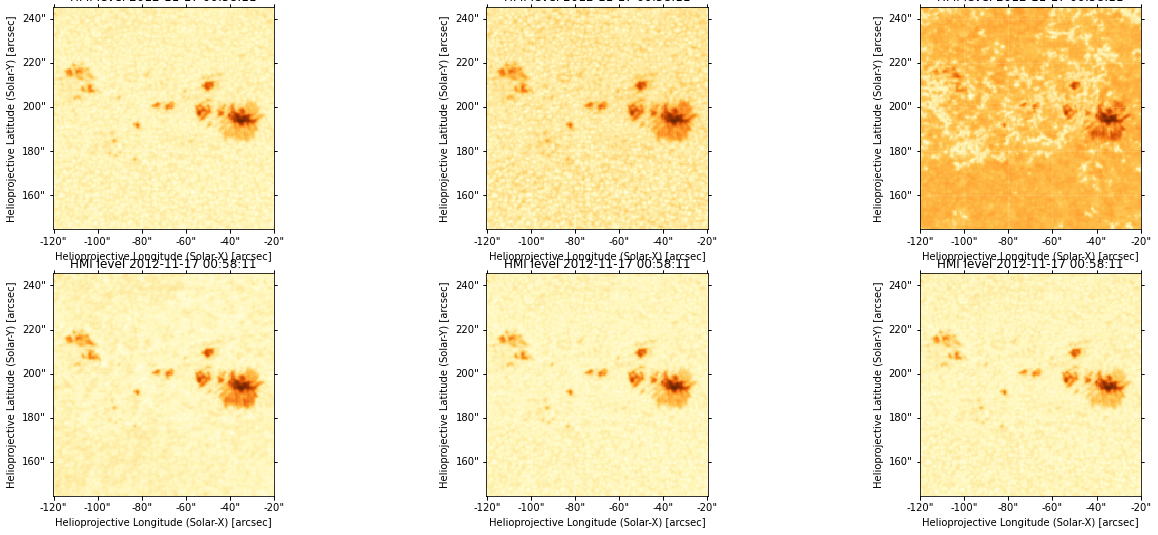

In [2]:
#Checking 6 wavelenghts files in 4 stokes parameters
#For a total of 24
sunspot_date = '20121117_010000'
sunspot_date1 = '2012-11-17T01:04:00'
folder_in = '/home/miguel/Solar-physics-project/Thesis/stokes_data/sub_stokes_'+sunspot_date1+'/'
files_I = sorted(glob.glob(folder_in+'submap.hmi.s_720s.'+str(sunspot_date)+'_TAI.1.I*.fits'))
files_Q = sorted(glob.glob(folder_in+'submap.hmi.s_720s.'+str(sunspot_date)+'_TAI.1.Q*.fits'))
files_U = sorted(glob.glob(folder_in+'submap.hmi.s_720s.'+str(sunspot_date)+'_TAI.1.U*.fits'))
files_V = sorted(glob.glob(folder_in+'submap.hmi.s_720s.'+str(sunspot_date)+'_TAI.1.V*.fits'))

print(files_I[0])
print(' ')
print(files_I[1])
print(' ')
print(files_I[5])

fig = plt.figure(figsize=(22,9))
for i in range(1,7):
    xmap = smap.Map(files_I[i-1])
    xmap.plot_settings['cmap'] = plt.cm.YlOrBr_r
    ax = fig.add_subplot(2,3,i, projection=xmap)
    xmap.plot()
    
    
    

In [3]:
#[arcsec/pixel] value

hdul = fits.open(files_I[0][:])
hdul.info()

print('longitude [arcsec/pixel] = ',hdul[0].header['CDELT1'])
print('latitude [arcsec/pixel] = ',hdul[0].header['CDELT2'])

Filename: /home/miguel/Solar-physics-project/Thesis/stokes_data/sub_stokes_2012-11-17T01:04:00/submap.hmi.s_720s.20121117_010000_TAI.1.I0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     111   (199, 200)   float32   
longitude [arcsec/pixel] =  0.504298508
latitude [arcsec/pixel] =  0.504298508


# 1.2. Obtain Stokes data from fits files

In [4]:
data = fits.getdata(files_I[0])
print('Maps shape: ',data.shape)

n_rows = len(data) #number of pixels in x
n_colums = len(data[0]) #numver of pixels in y

print('number of rows: ',n_rows)
print('number of columns: ',n_colums)

stokes_i = np.zeros([6,n_rows,n_colums])
stokes_q = np.zeros([6,n_rows,n_colums])
stokes_u = np.zeros([6,n_rows,n_colums])
stokes_v = np.zeros([6,n_rows,n_colums])

for i in range(6):
    stokes_i[i,:,:] = fits.getdata(files_I[i])
    stokes_q[i,:,:] = fits.getdata(files_Q[i])
    stokes_u[i,:,:] = fits.getdata(files_U[i])
    stokes_v[i,:,:] = fits.getdata(files_V[i])
    
print('Stokes I map in 6 wavelenghts shape: ',stokes_i.shape)
print('Stokes Q map in 6 wavelenghts shape: ',stokes_q.shape)
print('Stokes U map in 6 wavelenghts shape: ',stokes_u.shape)
print('Stokes V map in 6 wavelenghts shape: ',stokes_v.shape)

Maps shape:  (200, 199)
number of rows:  200
number of columns:  199
Stokes I map in 6 wavelenghts shape:  (6, 200, 199)
Stokes Q map in 6 wavelenghts shape:  (6, 200, 199)
Stokes U map in 6 wavelenghts shape:  (6, 200, 199)
Stokes V map in 6 wavelenghts shape:  (6, 200, 199)


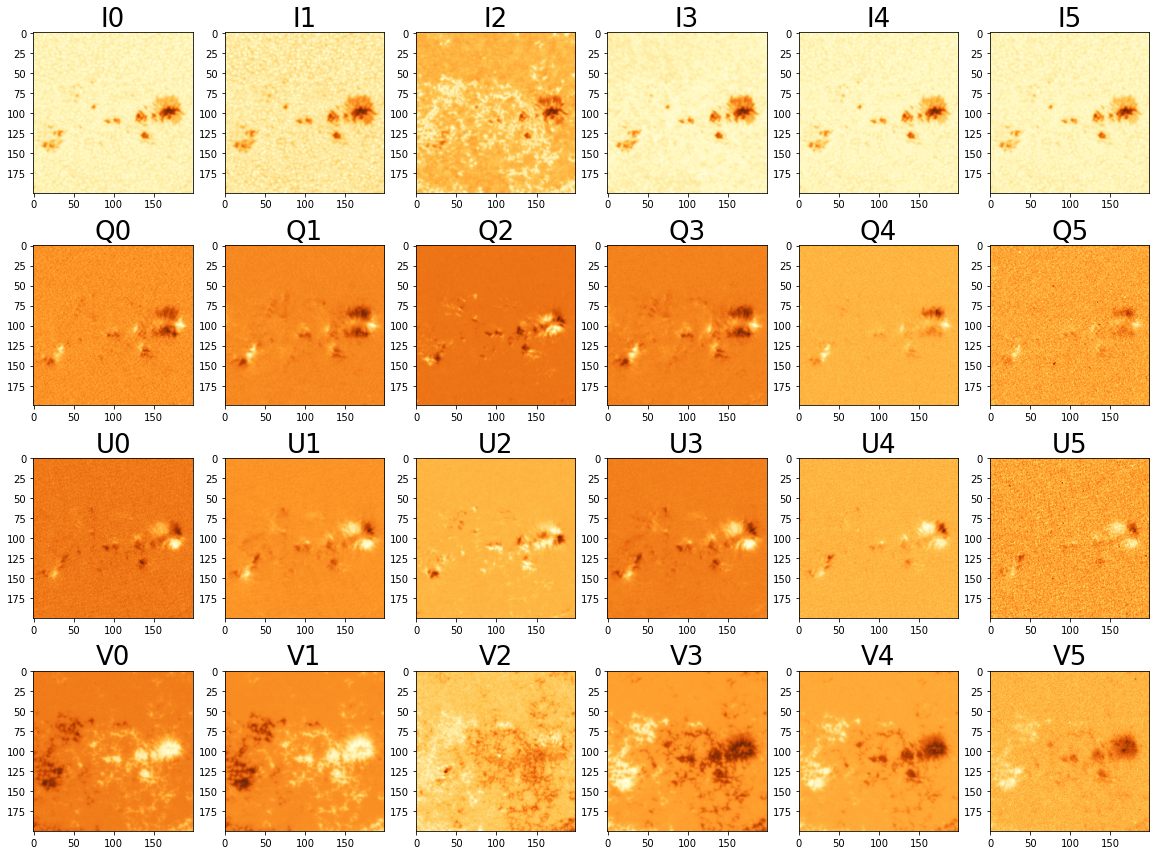

In [5]:
fig, axs = plt.subplots(4, 6,figsize=(20,15))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_i[i,:,:])
    axs[0,i].set_title('I%i'%i,fontsize=26)
    axs[1,i].imshow(stokes_q[i,:,:])
    axs[1,i].set_title('Q%i'%i,fontsize=26)
    axs[2,i].imshow(stokes_u[i,:,:])
    axs[2,i].set_title('U%i'%i,fontsize=26)
    axs[3,i].imshow(stokes_v[i,:,:])
    axs[3,i].set_title('V%i'%i,fontsize=26)

# 1.3. Obtaining polarized images

In [6]:
# stokes_i column vector, rows --> I0,I1,I2,I3,I4,I5 
# stokes_i                         Q0,Q1,Q2,Q3,Q4,Q5
# stokes_i                         U0,U1,U2,U3,U4,U5
# stokes_i                         V0,V1,V2,V3,V4,V5

#I0_means_0_0 = 1/2*(I0 + Q0*np.cos(2*0) + U0*np.cos(0)*np.sin(2*0) + V0*np.sin(0)*np.sin(2*0))

Sub_I_means = np.zeros((6,6,n_rows,n_colums))
for i in range(6): #I_means_0_0
    Sub_I_means[0,i,:,:] =  1/2*(stokes_i[i,:,:] + stokes_q[i,:,:]*np.cos(2*0) + 
                              stokes_u[i,:,:]*np.cos(0)*np.sin(2*0) + 
                              stokes_v[i,:,:]*np.sin(0)*np.sin(2*0))
for i in range(6): #I_means_90_0
    Sub_I_means[1,i,:,:] =  1/2*(stokes_i[i,:,:] + stokes_q[i,:,:]*np.cos(2*np.pi/2) + 
                              stokes_u[i,:,:]*np.cos(0)*np.sin(2*np.pi/2) + 
                              stokes_v[i,:,:]*np.sin(0)*np.sin(2*np.pi/2))
for i in range(6): #I_means_45_0
    Sub_I_means[2,i,:,:] =  1/2*(stokes_i[i,:,:] + stokes_q[i,:,:]*np.cos(2*np.pi/4) + 
                              stokes_u[i,:,:]*np.cos(0)*np.sin(2*np.pi/4) + 
                              stokes_v[i,:,:]*np.sin(0)*np.sin(2*np.pi/4))
for i in range(6): #I_means_135_0
    Sub_I_means[3,i,:,:] =  1/2*(stokes_i[i,:,:] + stokes_q[i,:,:]*np.cos(2*3*np.pi/4) + 
                              stokes_u[i,:,:]*np.cos(0)*np.sin(2*3*np.pi/4) + 
                              stokes_v[i,:,:]*np.sin(0)*np.sin(2*3*np.pi/4))
for i in range(6): #I_means_45_90
    Sub_I_means[4,i,:,:] =  1/2*(stokes_i[i,:,:] + stokes_q[i,:,:]*np.cos(2*np.pi/4) + 
                              stokes_u[i,:,:]*np.cos(np.pi/2)*np.sin(2*np.pi/4) + 
                              stokes_v[i,:,:]*np.sin(np.pi/2)*np.sin(2*np.pi/4))
for i in range(6): #I_means_135_90
    Sub_I_means[5,i,:,:] =  1/2*(stokes_i[i,:,:] + stokes_q[i,:,:]*np.cos(2*3*np.pi/4) + 
                              stokes_u[i,:,:]*np.cos(np.pi/2)*np.sin(2*3*np.pi/4) + 
                              stokes_v[i,:,:]*np.sin(np.pi/2)*np.sin(2*3*np.pi/4))

  
    
print(Sub_I_means.shape)

(6, 6, 200, 199)


In [7]:
#Checking stokes parameters reconstruction and plotting the polarize images
#                        |
#                        |
#                        |                        
#                        |
#                        |
#                       \| /
#                        \/ 

#[I0_0_0     I1_0_0     I2_0_0     I3_0_0     I4_0_0     I5_0_0
# I0_90_0    I1_90_0    I2_90_0    I3_90_0    I4_90_0    I5_90_0
# I0_45_0    I1_45_0    I2_45_0    I3_45_0    I4_45_0    I5_45_0
# I0_135_0   I1_135_0   I2_135_0   I3_135_0   I4_135_0   I5_135_0
# I0_45_90   I1_45_90   I2_45_90   I3_45_90   I4_45_90   I5_45_90
# I0_135_90  I1_135_90  I2_135_90  I3_135_90  I4_135_90  I5_135_90


In [8]:
Is_reconstructed = Sub_I_means[0,:] + Sub_I_means[1,:] #I0_0_0 + I0_90_0
Qs_reconstructed = Sub_I_means[0,:] - Sub_I_means[1,:] #I0_0_0 - I0_90_0
Us_reconstructed = Sub_I_means[2,:] - Sub_I_means[3,:]#I0_45_0 - I0_135_0
Vs_reconstructed = Sub_I_means[4,:] - Sub_I_means[5,:]#I0_45_90 - I0_135_90

Is_check = Is_reconstructed - stokes_i
Qs_check = Qs_reconstructed - stokes_q
Us_check = Us_reconstructed - stokes_u
Vs_check = Vs_reconstructed - stokes_v

#Original vs reconstruction from polarized images
print(np.max(Is_check),np.min(Is_check))
print(np.max(Qs_check),np.min(Qs_check))
print(np.max(Us_check),np.min(Us_check))
print(np.max(Vs_check),np.min(Vs_check))

print(int(np.max(Is_check)),int(np.max(Qs_check)),int(np.max(Us_check)),int(np.max(Vs_check))) #
print(Is_reconstructed.shape)

0.0 0.0
0.0 0.0
2.2737367544323206e-12 0.0
0.0 0.0
0 0 0 0
(6, 200, 199)


# 1.4. Checking Stokes reconstruction with the polarized images 

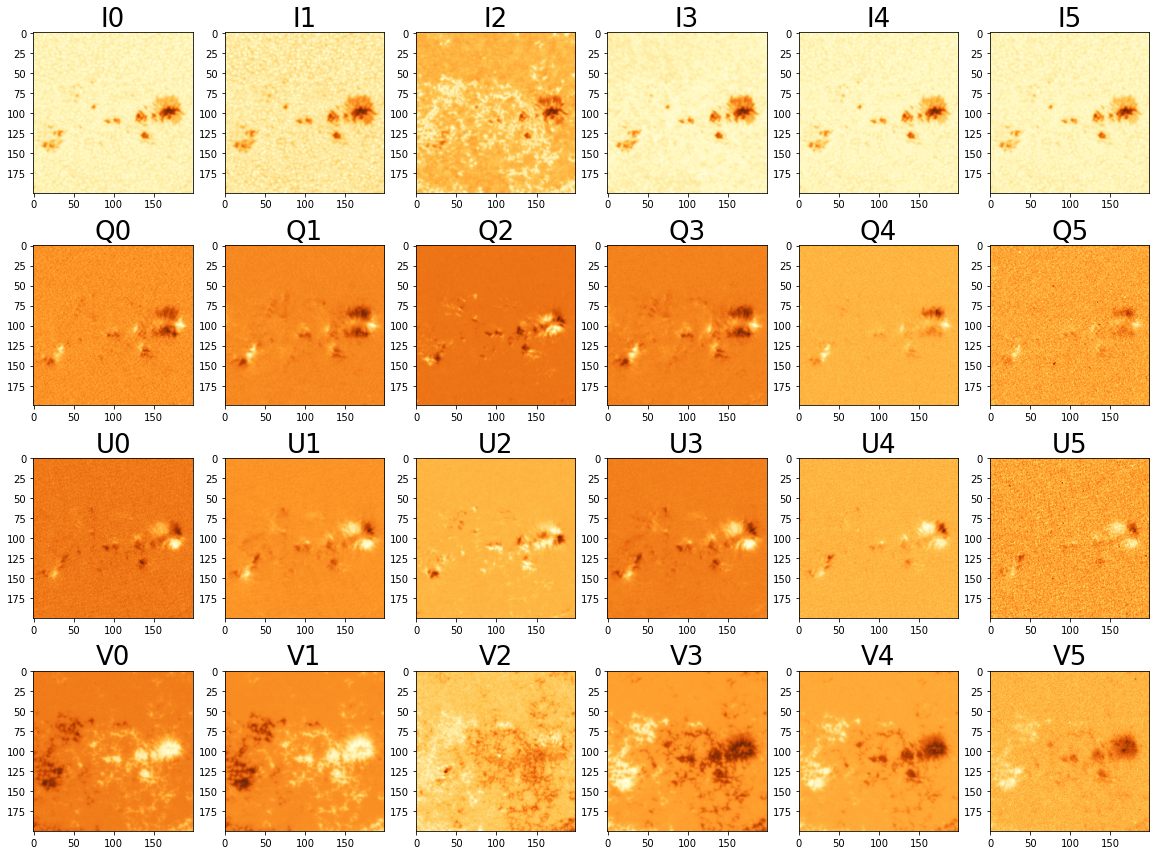

In [9]:
fig, axs = plt.subplots(4, 6,figsize=(20,15))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(Is_reconstructed[i,:,:])
    axs[0,i].set_title('I%i'%i,fontsize=26)
    axs[1,i].imshow(Qs_reconstructed[i,:,:])
    axs[1,i].set_title('Q%i'%i,fontsize=26)
    axs[2,i].imshow(Us_reconstructed[i,:,:])
    axs[2,i].set_title('U%i'%i,fontsize=26)
    axs[3,i].imshow(Vs_reconstructed[i,:,:])
    axs[3,i].set_title('V%i'%i,fontsize=26)

# 1.5. Plotting polarized images

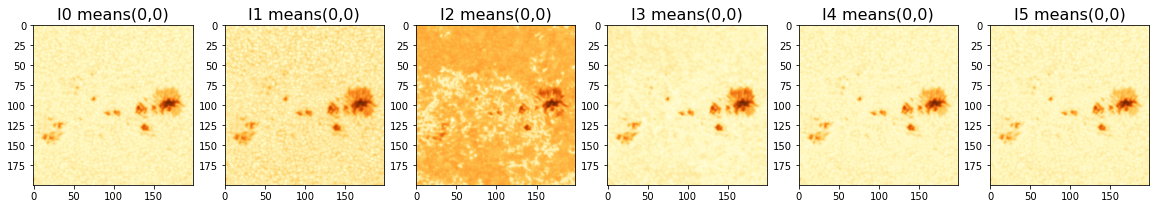

In [10]:
fig, axs = plt.subplots(1, 6,figsize=(20,25))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[i].set_title('I%i means(0,0)'%i,fontsize=16)
    axs[i].imshow(Sub_I_means[0,i,:,:])
  

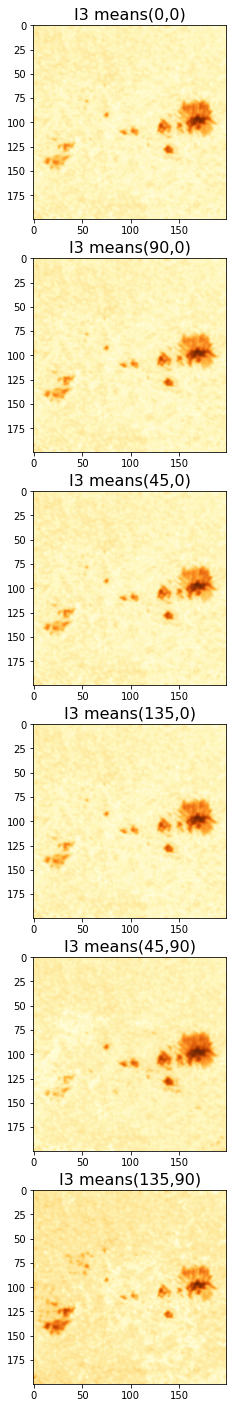

In [11]:
fig, axs = plt.subplots(6, 1,figsize=(7,25))
plt.set_cmap('YlOrBr_r')
axs[0].set_title('I3 means(0,0)',fontsize=16)
axs[0].imshow(Sub_I_means[0,3,:,:])
axs[1].set_title('I3 means(90,0)',fontsize=16)
axs[1].imshow(Sub_I_means[1,3,:,:])
axs[2].set_title('I3 means(45,0)',fontsize=16)
axs[2].imshow(Sub_I_means[2,3,:,:])
axs[3].set_title('I3 means(135,0)',fontsize=16)
axs[3].imshow(Sub_I_means[3,3,:,:])
axs[4].set_title('I3 means(45,90)',fontsize=16)
axs[4].imshow(Sub_I_means[4,3,:,:])
axs[5].set_title('I3 means(135,90)',fontsize=16)
axs[5].imshow(Sub_I_means[5,3,:,:])

# 1.6. Saving polarized images

In [12]:
path_pimages = '/home/miguel/Solar-physics-project/Thesis/atm_simulations/polarized_images/polarized_images_'+sunspot_date+'/'

In [13]:
if os.path.exists(path_pimages):
    shutil.rmtree(path_pimages)
os.makedirs(path_pimages)

fname_template0 = sunspot_date+"_I{i}_means_0_0.txt"
fname_template1 = sunspot_date+"_I{i}_means_90_0.txt"
fname_template2 = sunspot_date+"_I{i}_means_45_0.txt"
fname_template3 = sunspot_date+"_I{i}_means_135_0.txt"
fname_template4 = sunspot_date+"_I{i}_means_45_90.txt"
fname_template5 = sunspot_date+"_I{i}_means_135_90.txt"

In [14]:
for i in range(6):
    np.savetxt(path_pimages+fname_template0.format(i=i),Sub_I_means[0,i,:,:], fmt='%s',delimiter=',')
    np.savetxt(path_pimages+fname_template1.format(i=i),Sub_I_means[1,i,:,:], fmt='%s',delimiter=',')
    np.savetxt(path_pimages+fname_template2.format(i=i),Sub_I_means[2,i,:,:], fmt='%s',delimiter=',')
    np.savetxt(path_pimages+fname_template3.format(i=i),Sub_I_means[3,i,:,:], fmt='%s',delimiter=',')
    np.savetxt(path_pimages+fname_template4.format(i=i),Sub_I_means[4,i,:,:], fmt='%s',delimiter=',')
    np.savetxt(path_pimages+fname_template5.format(i=i),Sub_I_means[5,i,:,:], fmt='%s',delimiter=',')
    
#[I0_0_0     I1_0_0     I2_0_0     I3_0_0     I4_0_0     I5_0_0
# I0_90_0    I1_90_0    I2_90_0    I3_90_0    I4_90_0    I5_90_0
# I0_45_0    I1_45_0    I2_45_0    I3_45_0    I4_45_0    I5_45_0
# I0_135_0   I1_135_0   I2_135_0   I3_135_0   I4_135_0   I5_135_0
# I0_45_90   I1_45_90   I2_45_90   I3_45_90   I4_45_90   I5_45_90
# I0_135_90  I1_135_90  I2_135_90  I3_135_90  I4_135_90  I5_135_90

print(Sub_I_means.shape)

(6, 6, 200, 199)


In [15]:
#Checking data shape
Sub_Polarized_Images = sorted(glob.glob(path_pimages+'*.txt'))
print(Sub_Polarized_Images[0][115:])

data = pd.read_csv(Sub_Polarized_Images[0],header=None)
data.shape

7_010000_I0_means_0_0.txt


(200, 199)

# 1.7. Checking that the polarized images were saved correctly

In [16]:
for i in range(36):
    print(Sub_Polarized_Images[i][108:])
    
im = pd.read_csv(Sub_Polarized_Images[35][:],header=None)
im_array = np.asarray(im)
im_array_shape = im_array.shape
im_array_shape

20121117_010000_I0_means_0_0.txt
20121117_010000_I0_means_135_0.txt
20121117_010000_I0_means_135_90.txt
20121117_010000_I0_means_45_0.txt
20121117_010000_I0_means_45_90.txt
20121117_010000_I0_means_90_0.txt
20121117_010000_I1_means_0_0.txt
20121117_010000_I1_means_135_0.txt
20121117_010000_I1_means_135_90.txt
20121117_010000_I1_means_45_0.txt
20121117_010000_I1_means_45_90.txt
20121117_010000_I1_means_90_0.txt
20121117_010000_I2_means_0_0.txt
20121117_010000_I2_means_135_0.txt
20121117_010000_I2_means_135_90.txt
20121117_010000_I2_means_45_0.txt
20121117_010000_I2_means_45_90.txt
20121117_010000_I2_means_90_0.txt
20121117_010000_I3_means_0_0.txt
20121117_010000_I3_means_135_0.txt
20121117_010000_I3_means_135_90.txt
20121117_010000_I3_means_45_0.txt
20121117_010000_I3_means_45_90.txt
20121117_010000_I3_means_90_0.txt
20121117_010000_I4_means_0_0.txt
20121117_010000_I4_means_135_0.txt
20121117_010000_I4_means_135_90.txt
20121117_010000_I4_means_45_0.txt
20121117_010000_I4_means_45_90.txt

(200, 199)

In [17]:
PolarizedImages = np.ndarray((1,36,im_array_shape[0],im_array_shape[1]))
for i in range(len(Sub_Polarized_Images)):
    PolarizedImages[0][i] = np.asarray(pd.read_csv(Sub_Polarized_Images[i][:],header=None))
    
#I0_means_0_0, I0_means_135_0, I0_means_135_90, I0_means_45_0, I0_means_45_90, I0_means_90_0
print(Sub_Polarized_Images[0][126:],Sub_Polarized_Images[1][126:],Sub_Polarized_Images[2][126:])
print(PolarizedImages.shape)

_means_0_0.txt _means_135_0.txt _means_135_90.txt
(1, 36, 200, 199)


In [18]:
Array_polarizedImages = np.array([[PolarizedImages[0][0], PolarizedImages[0][6],  PolarizedImages[0][12], PolarizedImages[0][18], PolarizedImages[0][24], PolarizedImages[0][30]]
                                 ,[PolarizedImages[0][5], PolarizedImages[0][11], PolarizedImages[0][17], PolarizedImages[0][23], PolarizedImages[0][29], PolarizedImages[0][35]]
                                 ,[PolarizedImages[0][3], PolarizedImages[0][9],  PolarizedImages[0][15], PolarizedImages[0][21], PolarizedImages[0][27], PolarizedImages[0][33]]
                                 ,[PolarizedImages[0][1], PolarizedImages[0][7],  PolarizedImages[0][13], PolarizedImages[0][19], PolarizedImages[0][25], PolarizedImages[0][31]]
                                 ,[PolarizedImages[0][4], PolarizedImages[0][10], PolarizedImages[0][16], PolarizedImages[0][22], PolarizedImages[0][28], PolarizedImages[0][34]]
                                 ,[PolarizedImages[0][2], PolarizedImages[0][8],  PolarizedImages[0][14], PolarizedImages[0][20], PolarizedImages[0][26], PolarizedImages[0][32]]])

#([[I0_0_0,    I1_0_0,    I2_0_0,    I3_0_0,    I4_0_0,    I5_0_0]      
# ,[I0_90_0,   I1_90_0,   I2_90_0,   I3_90_0,   I4_90_0,   I5_90_0]     
# ,[I0_45_0,   I1_45_0,   I2_45_0,   I3_45_0,   I4_45_0,   I5_45_0]     
# ,[I0_135_0,  I1_135_0,  I2_135_0,  I3_135_0,  I4_135_0,  I5_135_0]    
# ,[I0_45_90,  I1_45_90,  I2_45_90,  I3_45_90,  I4_45_90,  I5_45_90]    
# ,[I0_135_90, I1_135_90, I2_135_90, I3_135_90, I4_135_90, I5_135_90])  

print('I0_0_0 - I0_0_0')
print(np.asarray(pd.read_csv(Sub_Polarized_Images[0][:],header=None)) - Array_polarizedImages[0][0])

print('I0_90_0 - I0_90_0')
print(np.asarray(pd.read_csv(Sub_Polarized_Images[5][:],header=None)) - Array_polarizedImages[1][0])

print('I0_45_0 - I0_45_0')
print(np.asarray(pd.read_csv(Sub_Polarized_Images[3][:],header=None)) - Array_polarizedImages[2][0])

print('I0_135_0 - I0_135_0')
print(np.asarray(pd.read_csv(Sub_Polarized_Images[1][:],header=None)) - Array_polarizedImages[3][0])

print('I0_45_90 - I0_45_90')
print(np.asarray(pd.read_csv(Sub_Polarized_Images[4][:],header=None)) - Array_polarizedImages[4][0])

print('I0_135_90 - I0_135_90')
print(np.asarray(pd.read_csv(Sub_Polarized_Images[2][:],header=None)) - Array_polarizedImages[5][0])

I0_0_0 - I0_0_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_90_0 - I0_90_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_45_0 - I0_45_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_135_0 - I0_135_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_45_90 - I0_45_90
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_135_90 - I0_135_90
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 

# 1.8. Checking the Stokes reconstruction with saved polarized images

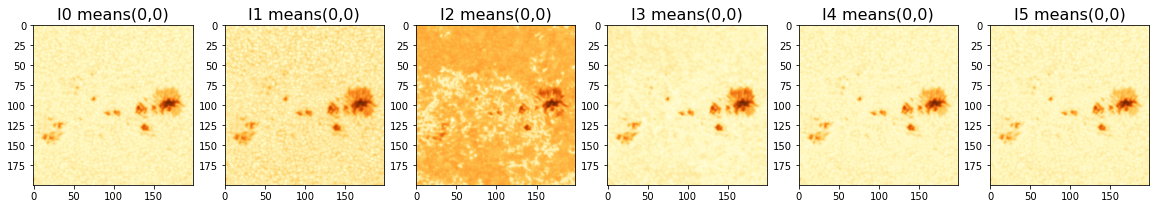

In [19]:
fig, axs = plt.subplots(1, 6,figsize=(20,25))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[i].set_title('I%i means(0,0)'%i,fontsize=16)
    axs[i].imshow(Array_polarizedImages[0,i,:,:])
  

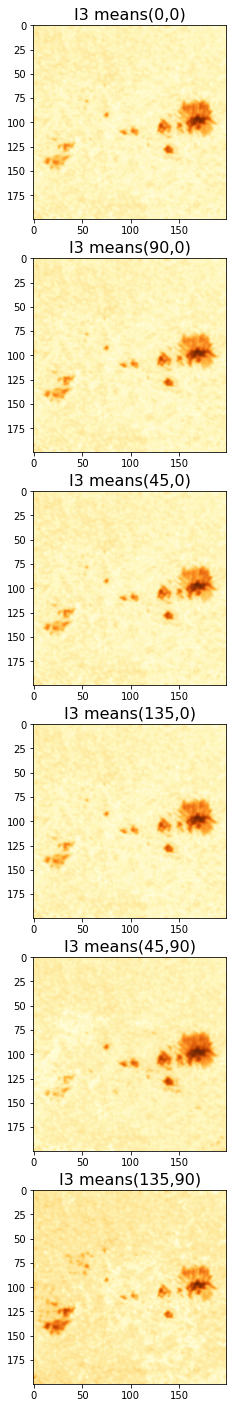

In [20]:
fig, axs = plt.subplots(6, 1,figsize=(7,25))
plt.set_cmap('YlOrBr_r')
axs[0].set_title('I3 means(0,0)',fontsize=16)
axs[0].imshow(Array_polarizedImages[0,3,:,:])
axs[1].set_title('I3 means(90,0)',fontsize=16)
axs[1].imshow(Array_polarizedImages[1,3,:,:])
axs[2].set_title('I3 means(45,0)',fontsize=16)
axs[2].imshow(Array_polarizedImages[2,3,:,:])
axs[3].set_title('I3 means(135,0)',fontsize=16)
axs[3].imshow(Array_polarizedImages[3,3,:,:])
axs[4].set_title('I3 means(45,90)',fontsize=16)
axs[4].imshow(Array_polarizedImages[4,3,:,:])
axs[5].set_title('I3 means(135,90)',fontsize=16)
axs[5].imshow(Array_polarizedImages[5,3,:,:])

In [21]:
Is_reconstructed = Array_polarizedImages[0,:] + Array_polarizedImages[1,:] #I0_0_0 + I0_90_0
Qs_reconstructed = Array_polarizedImages[0,:] - Array_polarizedImages[1,:] #I0_0_0 - I0_90_0
Us_reconstructed = Array_polarizedImages[2,:] - Array_polarizedImages[3,:]#I0_45_0 - I0_135_0
Vs_reconstructed = Array_polarizedImages[4,:] - Array_polarizedImages[5,:]#I0_45_90 - I0_135_90

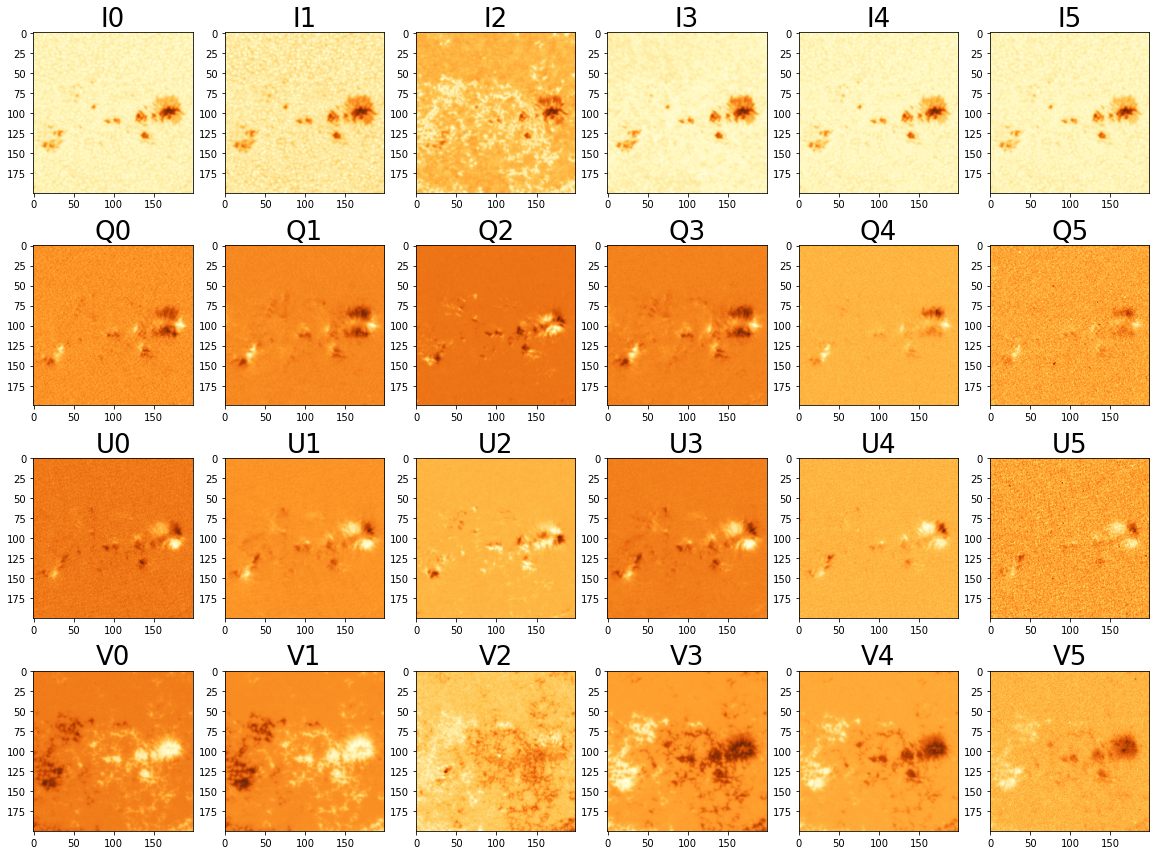

In [22]:
fig, axs = plt.subplots(4, 6,figsize=(20,15))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(Is_reconstructed[i,:,:])
    axs[0,i].set_title('I%i'%i,fontsize=26)
    axs[1,i].imshow(Qs_reconstructed[i,:,:])
    axs[1,i].set_title('Q%i'%i,fontsize=26)
    axs[2,i].imshow(Us_reconstructed[i,:,:])
    axs[2,i].set_title('U%i'%i,fontsize=26)
    axs[3,i].imshow(Vs_reconstructed[i,:,:])
    axs[3,i].set_title('V%i'%i,fontsize=26)

# Second part of the code

# 2.1. Checking aberrated polarized images

In [23]:
#Open image before atomospheric simulation
input_image = Sub_Polarized_Images[0]
im = pd.read_csv(input_image,header=None)
im_array = np.asarray(im)#Open image before atomospheric simulation

r0_cm = 1.5
path_pimages = '/home/miguel/Solar-physics-project/Thesis/atm_simulations/Atm_polarized_images/r0_cm'+str(r0_cm)+'_'+sunspot_date+'/'
im_atm = pd.read_csv(path_pimages+'Atm_r0_cm'+str(r0_cm)+'_'+sunspot_date+'_I0_means_0_0.txt',header=None)
im_array_atmosphere = np.asarray(im_atm)

Original image size:  (200, 199)
Atm image size:  (177, 177)


Text(0.5, 1.0, 'With atmosphere r0 = 1 cm')

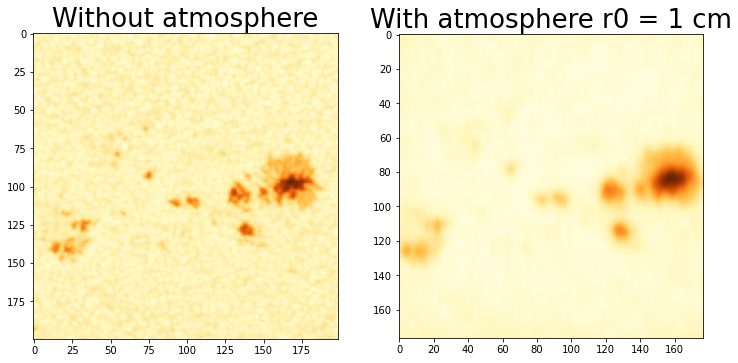

In [24]:
print('Original image size: ',im_array.shape)
print('Atm image size: ',im_array_atmosphere.shape)

fig, axs = plt.subplots(1, 2,figsize=(12,11.5))
axs[0].imshow(im_array,cmap = 'YlOrBr_r')
axs[0].set_title('Without atmosphere',fontsize=26)
axs[1].imshow(im_array_atmosphere,cmap = 'YlOrBr_r')
axs[1].set_title('With atmosphere r0 = %i cm'%r0_cm,fontsize=26)

# 2.2. Reconstructing aberrated Stokes parameters

In [25]:
#PolarizedImages_folder = '/home/miguel/Solar-physics-project/Proyecto Avanzado 2/Simulaciones atmosfera/ForStokes/output_images 2011.10.27/'
#PolarizedImages_data = sorted(glob.glob(PolarizedImages_folder+'*.png'))
#print(PolarizedImages_data[1][113:])

atm_shape = im_array_atmosphere.shape
print(atm_shape)

Atm_Polarized_Images = sorted(glob.glob(path_pimages+'*.txt'))
im = pd.read_csv(Atm_Polarized_Images[35][:],header=None)
im_array = np.asarray(im)
im_array_shape = im_array.shape

Atm_PolarizedImages = np.ndarray((1,36,atm_shape[0],atm_shape[1]))
for i in range(len(Atm_Polarized_Images)):
    Atm_PolarizedImages[0][i] = np.asarray(pd.read_csv(Atm_Polarized_Images[i][:],header=None))
    
#Atm_I0_means_0_0, Atm_I0_means_135_0, Atm_I0_means_135_90, Atm_I0_means_45_0, Atm_I0_means_45_90, Atm_I0_means_90_0
print(Atm_PolarizedImages.shape)


(177, 177)
(1, 36, 177, 177)


In [26]:
Array_Atm_PolarizedImages = np.array([[Atm_PolarizedImages[0][0], Atm_PolarizedImages[0][6], Atm_PolarizedImages[0][12], Atm_PolarizedImages[0][18], Atm_PolarizedImages[0][24], Atm_PolarizedImages[0][30]]
                                     ,[Atm_PolarizedImages[0][5], Atm_PolarizedImages[0][11], Atm_PolarizedImages[0][17], Atm_PolarizedImages[0][23], Atm_PolarizedImages[0][29], Atm_PolarizedImages[0][35]]
                                     ,[Atm_PolarizedImages[0][3], Atm_PolarizedImages[0][9], Atm_PolarizedImages[0][15], Atm_PolarizedImages[0][21], Atm_PolarizedImages[0][27], Atm_PolarizedImages[0][33]]
                                     ,[Atm_PolarizedImages[0][1], Atm_PolarizedImages[0][7], Atm_PolarizedImages[0][13], Atm_PolarizedImages[0][19], Atm_PolarizedImages[0][25], Atm_PolarizedImages[0][31]]
                                     ,[Atm_PolarizedImages[0][4], Atm_PolarizedImages[0][10], Atm_PolarizedImages[0][16], Atm_PolarizedImages[0][22], Atm_PolarizedImages[0][28], Atm_PolarizedImages[0][34]]
                                     ,[Atm_PolarizedImages[0][2], Atm_PolarizedImages[0][8], Atm_PolarizedImages[0][14], Atm_PolarizedImages[0][20], Atm_PolarizedImages[0][26], Atm_PolarizedImages[0][32]]])

#([[I0_0_0,    I1_0_0,    I2_0_0,    I3_0_0,    I4_0_0,    I5_0_0]      
# ,[I0_90_0,   I1_90_0,   I2_90_0,   I3_90_0,   I4_90_0,   I5_90_0]     
# ,[I0_45_0,   I1_45_0,   I2_45_0,   I3_45_0,   I4_45_0,   I5_45_0]     
# ,[I0_135_0,  I1_135_0,  I2_135_0,  I3_135_0,  I4_135_0,  I5_135_0]    
# ,[I0_45_90,  I1_45_90,  I2_45_90,  I3_45_90,  I4_45_90,  I5_45_90]    
# ,[I0_135_90, I1_135_90, I2_135_90, I3_135_90, I4_135_90, I5_135_90])  

In [27]:
print('I0_0_0 - I0_0_0')
print(np.asarray(pd.read_csv(Atm_Polarized_Images[0][:],header=None)) - Array_Atm_PolarizedImages[0][0])

print('I0_90_0 - I0_90_0')
print(np.asarray(pd.read_csv(Atm_Polarized_Images[5][:],header=None)) - Array_Atm_PolarizedImages[1][0])

print('I0_45_0 - I0_45_0')
print(np.asarray(pd.read_csv(Atm_Polarized_Images[3][:],header=None)) - Array_Atm_PolarizedImages[2][0])

print('I0_135_0 - I0_135_0')
print(np.asarray(pd.read_csv(Atm_Polarized_Images[1][:],header=None)) - Array_Atm_PolarizedImages[3][0])

print('I0_45_90 - I0_45_90')
print(np.asarray(pd.read_csv(Atm_Polarized_Images[4][:],header=None)) - Array_Atm_PolarizedImages[4][0])

print('I0_135_90 - I0_135_90')
print(np.asarray(pd.read_csv(Atm_Polarized_Images[2][:],header=None)) - Array_Atm_PolarizedImages[5][0])

I0_0_0 - I0_0_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_90_0 - I0_90_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_45_0 - I0_45_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_135_0 - I0_135_0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_45_90 - I0_45_90
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
I0_135_90 - I0_135_90
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 

In [28]:
Atm_Stokes=np.ndarray((4,6,atm_shape[0],atm_shape[1]))
#Stokes_Atm_Reconstructed=np.zeros((4,6))
for j in range(6):
    Atm_Stokes[0][j] = Array_Atm_PolarizedImages[0][j] + Array_Atm_PolarizedImages[1][j] #I 
    Atm_Stokes[1][j] = Array_Atm_PolarizedImages[0][j] - Array_Atm_PolarizedImages[1][j] #Q 
    Atm_Stokes[2][j] = Array_Atm_PolarizedImages[2][j] - Array_Atm_PolarizedImages[3][j] #U 
    Atm_Stokes[3][j] = Array_Atm_PolarizedImages[4][j] - Array_Atm_PolarizedImages[5][j] #V
#Stokes_Atm_Reconstructed
#array([[I0, I1, I2, I3, I4., I5],    
#       [Q0, Q1, Q2, Q3, Q4, Q5],     
#       [U0, U1, U2, U3, U4, U5],      
#       [V0, V1, V2, V3, V4, V5]])    

# 2.3. Comparing normal Stokes and atm Stokes

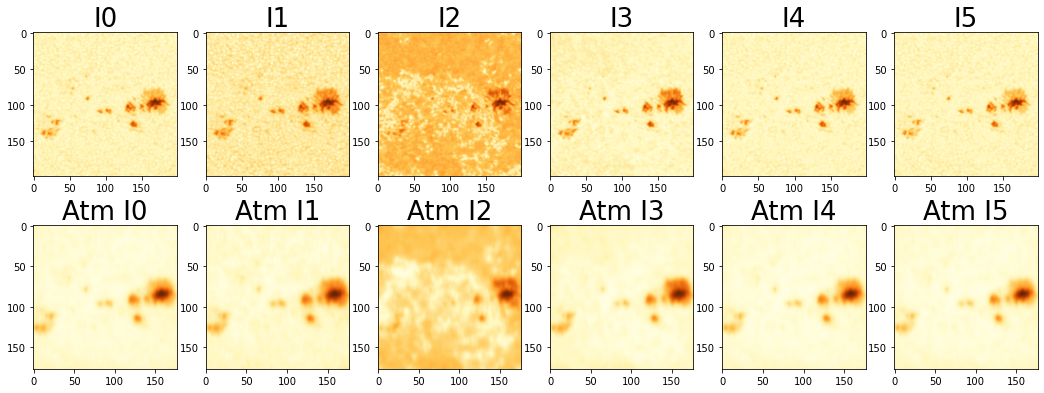

In [29]:
fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_i[i,:,:])
    axs[0,i].set_title('I%i'%i,fontsize=26)
    axs[1,i].imshow(Atm_Stokes[0][i])
    axs[1,i].set_title('Atm I%i'%i,fontsize=26)

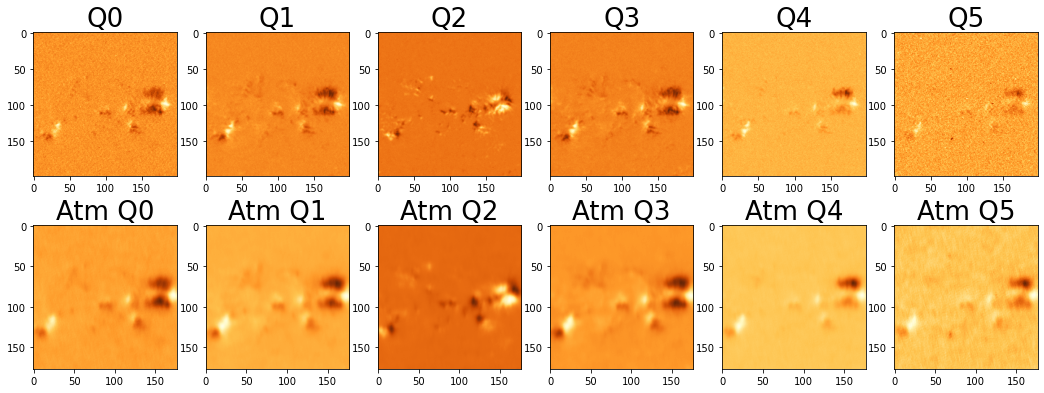

In [30]:
fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_q[i,:,:])
    axs[0,i].set_title('Q%i'%i,fontsize=26)
    axs[1,i].imshow(Atm_Stokes[1][i])
    axs[1,i].set_title('Atm Q%i'%i,fontsize=26)

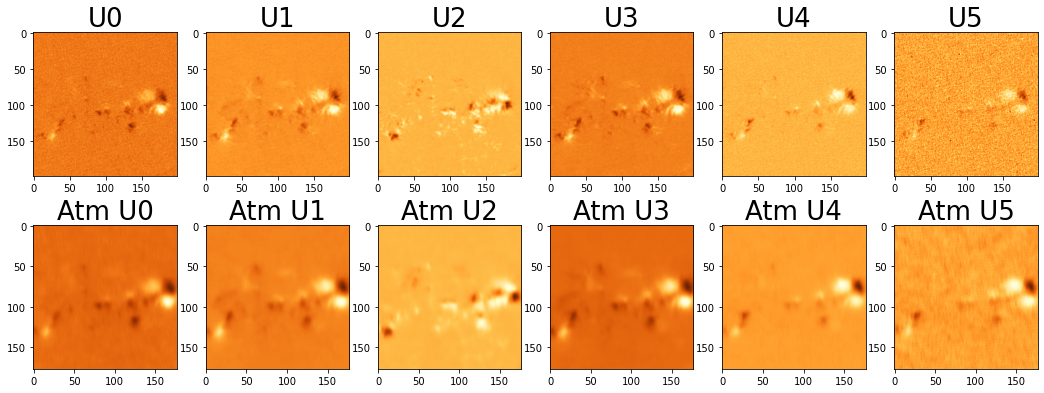

In [31]:
fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_u[i,:,:])
    axs[0,i].set_title('U%i'%i,fontsize=26)
    axs[1,i].imshow(Atm_Stokes[2][i])
    axs[1,i].set_title('Atm U%i'%i,fontsize=26)

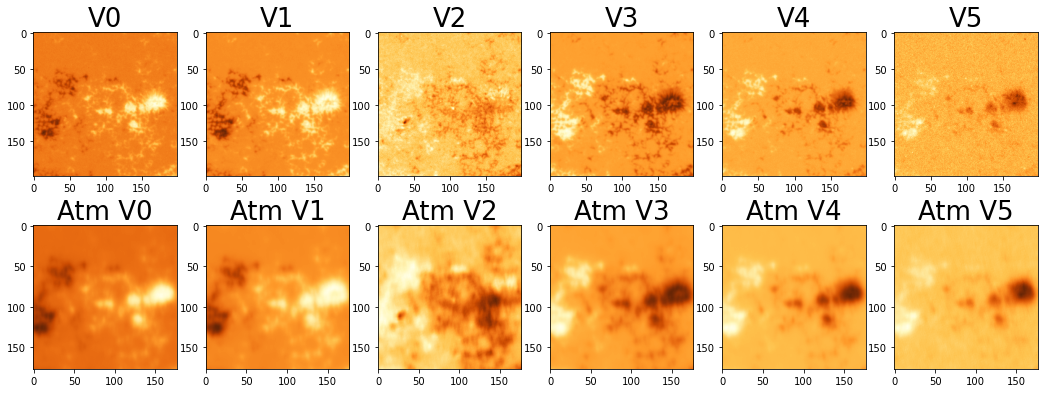

In [32]:
fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_v[i,:,:])
    axs[0,i].set_title('V%i'%i,fontsize=26)
    axs[1,i].imshow(Atm_Stokes[3][i])
    axs[1,i].set_title('Atm V%i'%i,fontsize=26)
    
    

# 2.4. Saving atm Stokes submaps

In [33]:
print(Atm_Stokes[3].shape)
print(len(Atm_Stokes[3]))

atm_stokes_i = np.zeros((atm_shape[0],atm_shape[1]))
atm_stokes_q = np.zeros((atm_shape[0],atm_shape[1]))
atm_stokes_u = np.zeros((atm_shape[0],atm_shape[1]))
atm_stokes_v = np.zeros((atm_shape[0],atm_shape[1]))

atm_stokes_i = Atm_Stokes[0,:,:]
atm_stokes_q = Atm_Stokes[1,:,:]
atm_stokes_u = Atm_Stokes[2,:,:]
atm_stokes_v = Atm_Stokes[3,:,:]

(6, 177, 177)
6


In [34]:
#organize file names 
n1=113
print(Atm_Polarized_Images[0][n1:])
print(sunspot_date)
print(sunspot_date1)



1.5_20121117_010000_I0_means_0_0.txt
20121117_010000
2012-11-17T01:04:00


In [35]:
path_pimages_u = '/home/miguel/Solar-physics-project/Thesis/stokes_data/atm_stokes_'+sunspot_date1+'/'+sunspot_date+'_atm_stokes_u_'+'r0_cm'+str(r0_cm)+'/'
path_pimages_i = '/home/miguel/Solar-physics-project/Thesis/stokes_data/atm_stokes_'+sunspot_date1+'/'+sunspot_date+'_atm_stokes_i_'+'r0_cm'+str(r0_cm)+'/'
path_pimages_q = '/home/miguel/Solar-physics-project/Thesis/stokes_data/atm_stokes_'+sunspot_date1+'/'+sunspot_date+'_atm_stokes_q_'+'r0_cm'+str(r0_cm)+'/'
path_pimages_v = '/home/miguel/Solar-physics-project/Thesis/stokes_data/atm_stokes_'+sunspot_date1+'/'+sunspot_date+'_atm_stokes_v_'+'r0_cm'+str(r0_cm)+'/'

In [36]:
if os.path.exists(path_pimages_u):
    shutil.rmtree(path_pimages_u)
os.makedirs(path_pimages_u)

for i in range(len(Atm_Stokes[2])):
    fname_template = 'stokes_u{i}_r0_cm'+str(r0_cm)+'_'+Atm_Polarized_Images[0][n1:]
    np.savetxt(path_pimages_u+fname_template.format(i=i),
              atm_stokes_u[i,:,:], 
               fmt='%s',delimiter=',')
    
    
if os.path.exists(path_pimages_i):
    shutil.rmtree(path_pimages_i)
os.makedirs(path_pimages_i)

for i in range(len(Atm_Stokes[0])):
    fname_template = 'stokes_i{i}_r0_cm'+str(r0_cm)+'_'+ Atm_Polarized_Images[0][n1:]#+'.txt'
    np.savetxt(path_pimages_i+fname_template.format(i=i),
              atm_stokes_i[i,:,:], 
               fmt='%s',delimiter=',')
    
    
if os.path.exists(path_pimages_q):
    shutil.rmtree(path_pimages_q)
os.makedirs(path_pimages_q)

for i in range(len(Atm_Stokes[1])):
    fname_template = 'stokes_q{i}_r0_cm'+str(r0_cm)+'_'+ Atm_Polarized_Images[0][n1:]#+'.txt'
    np.savetxt(path_pimages_q+fname_template.format(i=i),
              atm_stokes_q[i,:,:], 
               fmt='%s',delimiter=',')
    

if os.path.exists(path_pimages_v):
    shutil.rmtree(path_pimages_v)
os.makedirs(path_pimages_v)

for i in range(len(Atm_Stokes[3])):
    fname_template = 'stokes_v{i}_r0_cm'+str(r0_cm)+'_'+ Atm_Polarized_Images[0][n1:]#+'.txt'
    np.savetxt(path_pimages_v+fname_template.format(i=i),
              atm_stokes_v[i,:,:], 
               fmt='%s',delimiter=',')

# 2.5. Checking saved atm Stokes

(177, 177)
5/stokes_i0_r0_cm1.5_1.5_20121117_010000_I0_means_0_0.txt
(6, 177, 177)


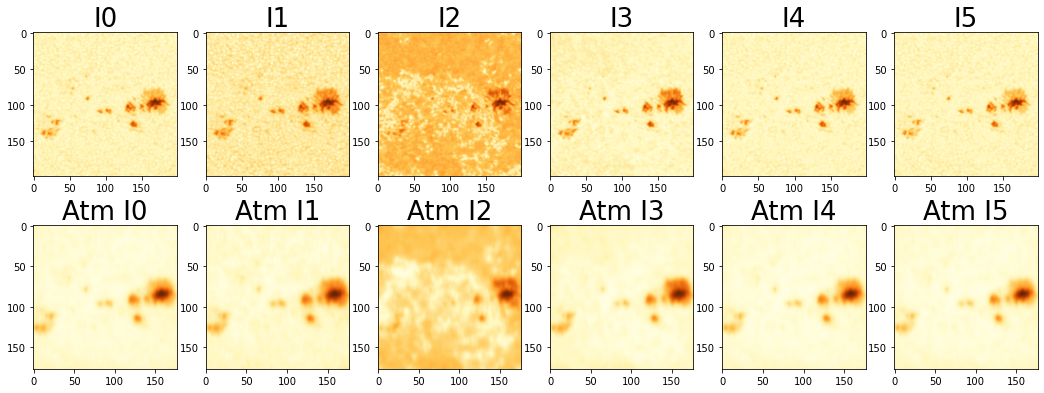

In [37]:
print(atm_shape)
#print(check_v_atm.shape)

check_atm_stokes_i = sorted(glob.glob(path_pimages_i+'*.txt'))
print(check_atm_stokes_i[0][121:])

check_i_atm = np.zeros((len(stokes_v),atm_shape[0],atm_shape[1]))
array_check_i_atm = check_i_atm

for i in range(6):
    check_i_atm[i,:,:] = pd.read_csv(check_atm_stokes_i[i][:],header=None)
    array_check_i_atm[i,:,:] = np.asarray(check_i_atm[i,:,:])

print(check_i_atm.shape)

fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_i[i,:,:])
    axs[0,i].set_title('I%i'%i,fontsize=26)
    axs[1,i].imshow(array_check_i_atm[i,:,:])
    axs[1,i].set_title('Atm I%i'%i,fontsize=26)

_r0_cm1.5/stokes_q0_r0_cm1.5_1.5_20121117_010000_I0_means_0_0.txt
(6, 177, 177)


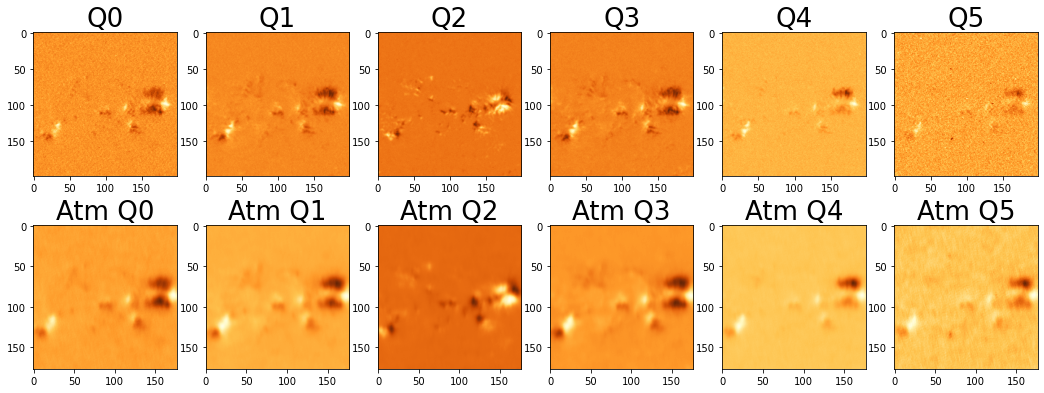

In [38]:
check_atm_stokes_q = sorted(glob.glob(path_pimages_q+'*.txt'))
print(check_atm_stokes_q[0][113:])

check_q_atm = np.zeros((len(stokes_v),atm_shape[0],atm_shape[1]))
array_check_q_atm = check_q_atm

for i in range(6):
    check_q_atm[i,:,:] = pd.read_csv(check_atm_stokes_q[i][:],header=None)
    array_check_q_atm[i,:,:] = np.asarray(check_q_atm[i,:,:])

print(check_q_atm.shape)

fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_q[i,:,:])
    axs[0,i].set_title('Q%i'%i,fontsize=26)
    axs[1,i].imshow(array_check_q_atm[i,:,:])
    axs[1,i].set_title('Atm Q%i'%i,fontsize=26)

_r0_cm1.5/stokes_u0_r0_cm1.5_1.5_20121117_010000_I0_means_0_0.txt
(6, 177, 177)


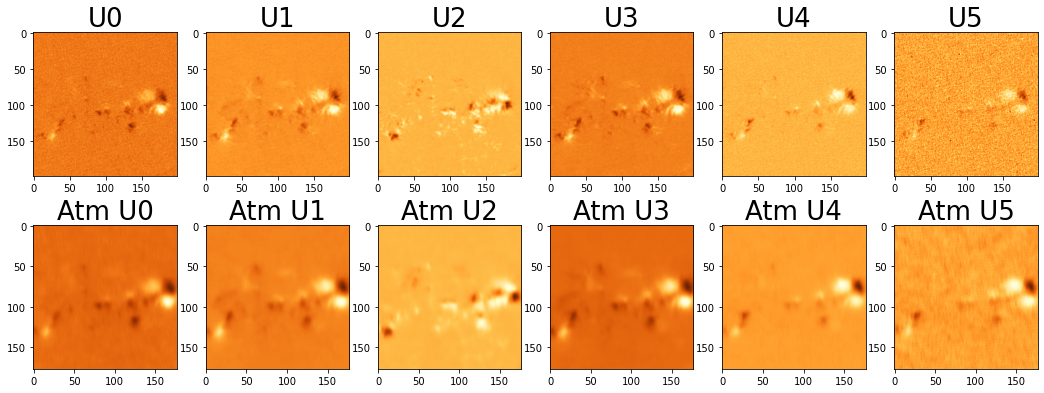

In [39]:
check_atm_stokes_u = sorted(glob.glob(path_pimages_u+'*.txt'))
print(check_atm_stokes_u[0][113:])

check_u_atm = np.zeros((len(stokes_v),atm_shape[0],atm_shape[1]))
array_check_u_atm = check_u_atm

for i in range(6):
    check_u_atm[i,:,:] = pd.read_csv(check_atm_stokes_u[i][:],header=None)
    array_check_u_atm[i,:,:] = np.asarray(check_u_atm[i,:,:])

print(check_u_atm.shape)

fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_u[i,:,:])
    axs[0,i].set_title('U%i'%i,fontsize=26)
    axs[1,i].imshow(array_check_u_atm[i,:,:])
    axs[1,i].set_title('Atm U%i'%i,fontsize=26)

_r0_cm1.5/stokes_v0_r0_cm1.5_1.5_20121117_010000_I0_means_0_0.txt
(6, 177, 177)


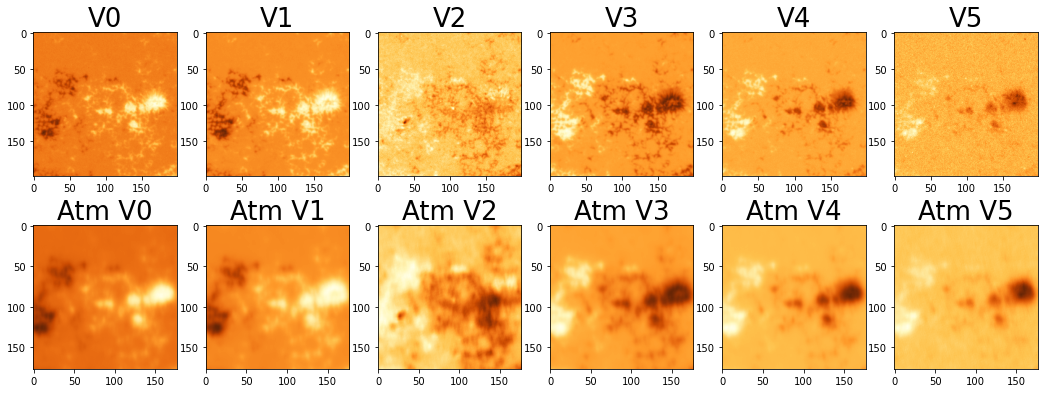

In [40]:
check_atm_stokes_v = sorted(glob.glob(path_pimages_v+'*.txt'))
print(check_atm_stokes_v[0][113:])

check_v_atm = np.zeros((len(stokes_v),atm_shape[0],atm_shape[1]))
array_check_v_atm = check_v_atm

for i in range(6):
    check_v_atm[i,:,:] = pd.read_csv(check_atm_stokes_v[i][:],header=None)
    array_check_v_atm[i,:,:] = np.asarray(check_v_atm[i,:,:])

print(check_v_atm.shape)

fig, axs = plt.subplots(2, 6,figsize=(18,6.5))
plt.set_cmap('YlOrBr_r')
for i in range(6):
    axs[0,i].imshow(stokes_v[i,:,:])
    axs[0,i].set_title('V%i'%i,fontsize=26)
    axs[1,i].imshow(array_check_v_atm[i,:,:])
    axs[1,i].set_title('Atm V%i'%i,fontsize=26)